# Setup

### trying to use tensorflow this week

As usual, we'll start by importing some libraries.

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path
import os

Next, we'll setup our dataset.

In [3]:
datapath = Path(os.path.join(os.getcwd(),"data"))
train_path = Path(os.path.join(datapath,"train"))
test_path = Path(os.path.join(datapath,"test"))
csv_path = Path(os.path.join(datapath,"bbox.csv"))

Since `cv2`, the library we'll be using to plot the bounding boxes and the images, only accepts integer values as vertices, we'll need to convert the coordinates of the bounding boxes to integers.

The dataset contains information about multi-object detection; however, this notebook is concerned with single object detection. To account for this slight discrepancy, we will omit the duplicate values of the `image` column. This results in each image having only one corresponding set of bounding box coordinates. 

In [4]:
train = pd.read_csv(csv_path)
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Next, I'll create some utility functions that make it easy to display images from files and dataframes.

In [60]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, 40) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])
        

**A quick formatting note**: the green rectangle represents the correct bounding whereas the red rectangle represents the predicted bounding box. This convention is used throughout this notebook.

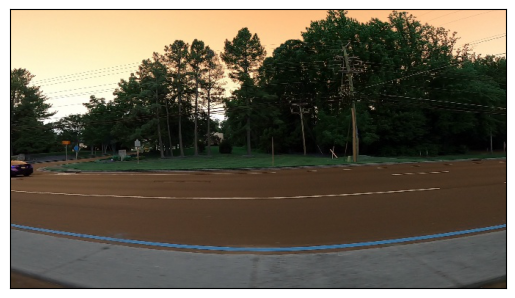

In [6]:
display_image_from_file("vid_4_10520.jpg")

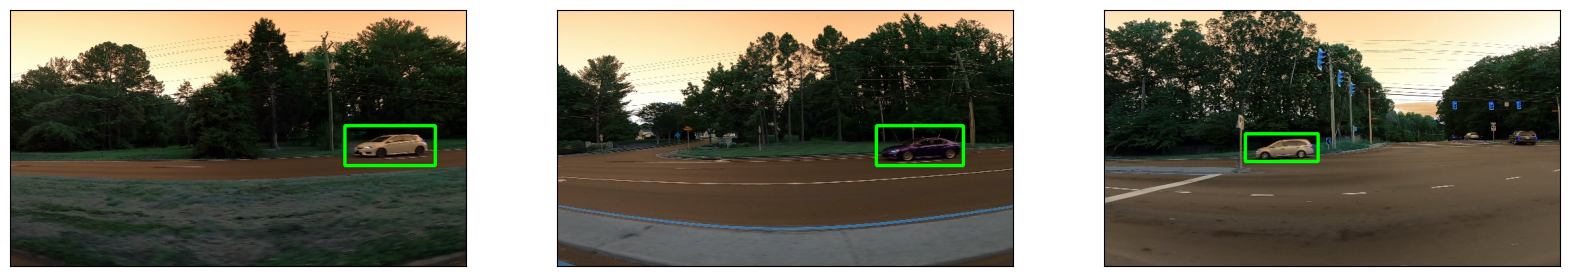

In [61]:
display_grid()

In [62]:
img = cv2.imread(os.path.join(train_path, "vid_4_12320.jpg"))
print(img.shape)
# make sure you are using this method!!

(380, 676, 3)


The functions work perfectly, and the logic for the bounding boxes seems to be flawless. We can now move on to creating and training the model.

# Model Training

## Data Generator

Before training the model, we must define a generator that keras accepts. If you're not familiar with python generators or are in need of a quick refresher, check out [this resource](https://www.programiz.com/python-programming/generator).

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

In [7]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}
        

The dictionary keys are crucial, as keras needs them to locate the correct input/output.

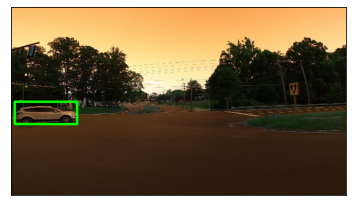

In [8]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

## Model Building

I'll use keras' functional API as it's incredibly easy to utilize custom inputs and predict custom outputs. Specifically, I'll use a fairly large neural network to start out with, and adjust the parameters of the layers if necessary.

Notice that the dictionary keys in the generator correspond to the names of the input and output layers.

In [9]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 380, 676, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 380, 676, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 380, 676, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 190, 338, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 190, 338, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 190, 338, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 169, 16)       0     

100 million parameters! I suppose that's fine for now; although, if I consider exporting this model, I will be left with a very very large file.

Moving on, we'll compile the model.

For each output, we need to specify a loss and a metric. To do this, we simply reference the dictionary key used in the generator and assign it our desired loss function/metric.

In [10]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Before we actually train the model, let's define a callback that tests the current model on three, randomly selected images.

In [11]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

We'll quickly use these methods to evaluate the current performance of our model.

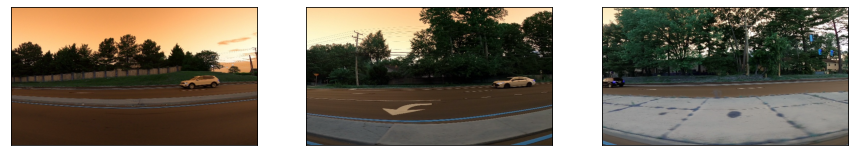

In [12]:
test(model)

The model isn't great; in fact, its predictions aren't even visible.

But, the model's poor performance is expected as we haven't even trained the model yet.
So, let's do just that.

We'll use Kaggle's GPU to train the model in order to drastically speed up the training process.

Epoch 1/9
500/500 [==============================] - 132s 260ms/step - loss: 4669.4341 - accuracy: 0.8670


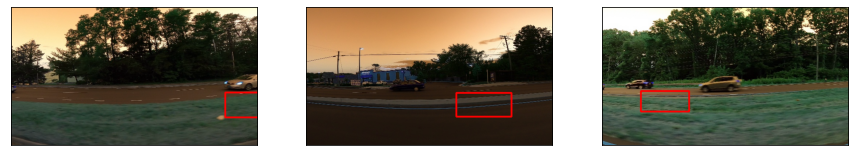

Epoch 2/9
500/500 [==============================] - 127s 255ms/step - loss: 1187.1774 - accuracy: 0.9582


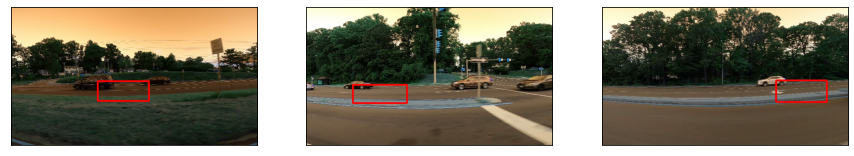

Epoch 3/9
500/500 [==============================] - 127s 254ms/step - loss: 391.1608 - accuracy: 0.9740


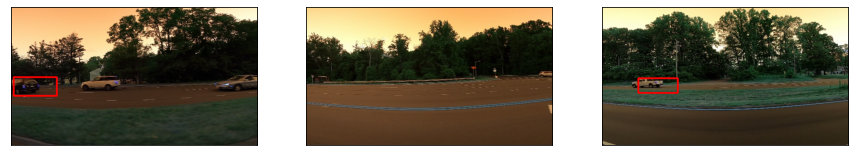

Epoch 4/9
500/500 [==============================] - 127s 255ms/step - loss: 265.1284 - accuracy: 0.9787


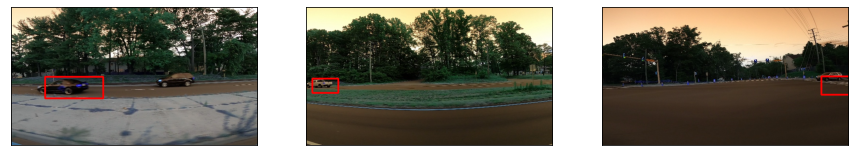

Epoch 5/9
500/500 [==============================] - 127s 254ms/step - loss: 162.3200 - accuracy: 0.9874


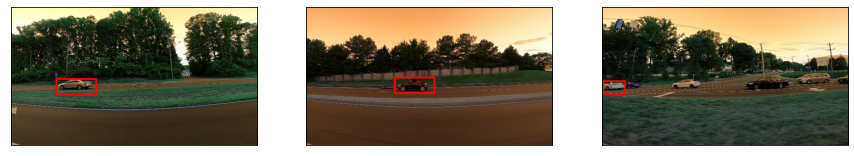

Epoch 6/9
500/500 [==============================] - 127s 254ms/step - loss: 108.9051 - accuracy: 0.9883


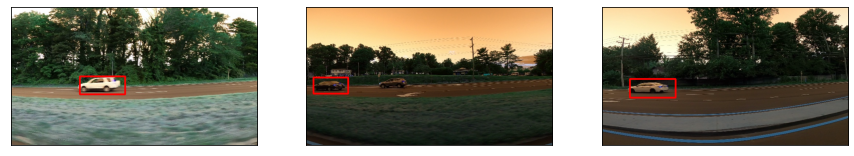

Epoch 7/9
500/500 [==============================] - 127s 254ms/step - loss: 109.2790 - accuracy: 0.9901


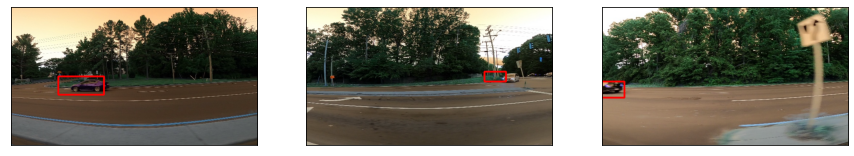

Epoch 8/9
500/500 [==============================] - 127s 255ms/step - loss: 94.5567 - accuracy: 0.9905


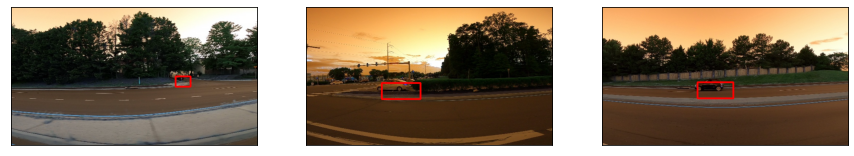

Epoch 9/9
500/500 [==============================] - 128s 256ms/step - loss: 116.7193 - accuracy: 0.9908


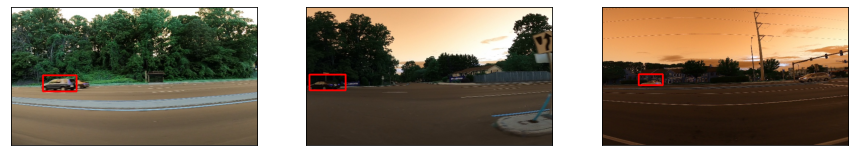

In [13]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

The model is doing quite well; the `MSE` is relatively low and the accuracy is very high.

Since the model training seems to be complete, we can now export the model and store it for later use.

In [14]:
model.save('car-object-detection.h5')

# Conclusion
This notebook described the setup of a single object detection model, along with the training process. Moreover, this notebook provided some insight on how to deal with datasets that aren't necessarily in a format compatible with the default keras settings. Lastly, this notebook described the thinking that goes behind approaching a computer vision problem such as single object detection.

For those eager to dive deeper, here are some more computer vision projects:
 - Image Segmentation
 - Single Object Detection (with videos)
 - Multiple Object Detection (with images)
 - Multiple Object Detection (with videos)
 - Object Detection and Classification (with images and videos)
 
If you found this notebook helpful, consider upvoting. Upvotes allow this notebook to circulate around Kaggle, thus resulting in the notebook reaching and helping more people.